In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow tensorflow-datasets librosa soundfile


In [3]:
import zipfile

# Define paths
speech_zip_path = '/content/drive/MyDrive/RAVDESS/Audio_Speech_Actors_01-24.zip'
extract_path = '/content/RAVDESS/Speech'

# Extract the dataset
with zipfile.ZipFile(speech_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Data Preprocessing and TensorFlow Dataset Creation


In [95]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import Audio, display
import random
import glob

In [107]:
# Mapping of emotion identifiers to their corresponding labels
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

emotions = emotion_map  # For consistency with the new load_data function

In [108]:
def extract_features(audio, sr=48000, feature_type='mfcc', num_features=40, delta=False, max_pad_len=862):
    """
    Extract features from an audio signal and pad/truncate to a fixed length.

    Parameters:
    - audio: np.array
        Audio signal from which features are to be extracted.
    - sr: int, optional
        Sampling rate of the audio signal. Default is 48000.
    - feature_type: str, optional
        Type of feature to extract. Options are 'mfcc', 'mel', 'stft'. Default is 'mfcc'.
    - num_features: int, optional
        Number of features to extract. Default is 40.
    - delta: bool, optional
        Whether to include delta and delta-delta features. Default is False.
    - max_pad_len: int, optional
        Maximum length to pad/truncate the features. Default is 862.

    Returns:
    - features: np.array
        Extracted and padded/truncated features.
    """
    if len(audio) == 0:
        print("Empty audio signal encountered.")
        return None

    try:
        if feature_type == 'mfcc':
            features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_features)
        elif feature_type == 'mel':
            features = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=num_features)
        elif feature_type == 'stft':
            features = np.abs(librosa.stft(y=audio, n_fft=512))

        if delta:
            delta_feat = librosa.feature.delta(features)
            delta_delta_feat = librosa.feature.delta(features, order=2)
            features = np.concatenate((features, delta_feat, delta_delta_feat), axis=0)

        features = np.clip(features, a_min=-1e10, a_max=1e10)

        if features.shape[1] > max_pad_len:
            features = features[:, :max_pad_len]
        else:
            pad_width = max_pad_len - features.shape[1]
            features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')

        features = np.nan_to_num(features)

        return features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

In [109]:
# Function to plot a spectrogram
def plot_spectrogram(spectrogram, label, sr=22050):
    plt.figure(figsize=(10, 4))
    if spectrogram.ndim == 2:
        plt.imshow(librosa.power_to_db(spectrogram, ref=np.max), aspect='auto', origin='lower', cmap='viridis')
    elif spectrogram.ndim == 3:
        plt.imshow(librosa.power_to_db(spectrogram[:, :, 0], ref=np.max), aspect='auto', origin='lower', cmap='viridis')
    plt.title(f'Label: {label}')
    plt.ylabel('Frequency bins')
    plt.xlabel('Time frames')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def check_audio_sample(X, y, index, label_encoder, sr=48000, audio_files=None):
    import matplotlib.pyplot as plt
    from IPython.display import Audio

    if index < len(X):
        sample = X[index]
        if sample.shape[0] == 1:
            sample = sample.squeeze(axis=0)

        label = label_encoder.inverse_transform([y[index]])[0]
        emotion = emotion_map.get(label, 'Unknown')

        print(f'Emotion: {emotion}')
        print(f'Sample shape: {sample.shape}')

        # Plotting the sample
        plt.imshow(sample, cmap='viridis')
        plt.title(f'Emotion: {emotion}')
        plt.colorbar()
        plt.show()

        if audio_files:
            audio_path = audio_files[index]
            audio_data, _ = librosa.load(audio_path, sr=sr)
            return Audio(audio_data, rate=sr)

        return None
    else:
        print("Index out of range.")
        return False

In [110]:
def noise(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def shift(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

def pitch_shift(audio, sr, pitch_factor=2):
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=pitch_factor)

def time_stretch(audio, stretch_factor=0.8):
    return librosa.effects.time_stretch(y=audio, rate=stretch_factor)

In [111]:
# Emotion map based on RAVDESS naming convention
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_feature(data, sr, mfcc=True, chroma=True, mel=True):
    result = np.array([])

    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        stft = np.abs(librosa.stft(data))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
        result = np.hstack((result, mel))

    return result

def load_data(dataset_path, feature_type='mfcc', num_features=40, delta=False, augment=False, fixed_length=300, save=False):
    x = []
    y = []
    audio_files = []

    # List all files in the dataset_path and sort to maintain consistent order
    all_files = sorted(glob.glob(os.path.join(dataset_path, "Actor_*/*.wav")))
    print(f"Total files found: {len(all_files)}")

    for file in all_files:
        file_name = os.path.basename(file)
        emotion_code = file_name.split("-")[2]
        emotion = emotion_map.get(emotion_code, 'Unknown')
        y.append(emotion)
        audio_files.append(file)

        audio, sr = librosa.load(file, sr=48000)
        features = extract_features(audio, sr, feature_type=feature_type, num_features=num_features, delta=delta, max_pad_len=fixed_length)
        if features is not None and features.shape[1] > 0:  # Check for valid features
            x.append(features)

            if augment:
                n_data = noise(audio, 0.001)
                n_feature = extract_features(n_data, sr, feature_type=feature_type, num_features=num_features, delta=delta, max_pad_len=fixed_length)
                if n_feature is not None and n_feature.shape[1] > 0:
                    x.append(n_feature)
                    y.append(emotion)
                    audio_files.append(file)  # Ensure the augmented data points have their corresponding audio file paths

                s_data = shift(audio, sr, 0.25, 'right')
                s_feature = extract_features(s_data, sr, feature_type=feature_type, num_features=num_features, delta=delta, max_pad_len=fixed_length)
                if s_feature is not None and s_feature.shape[1] > 0:
                    x.append(s_feature)
                    y.append(emotion)
                    audio_files.append(file)  # Ensure the augmented data points have their corresponding audio file paths

    x = np.array(x)
    y = np.array(y)
    audio_files = np.array(audio_files)

    if save:
        np.save('X.npy', x)
        np.save('y.npy', y)
        np.save('audio_files.npy', audio_files)

    return x, y, audio_files


In [112]:
# Example usage
dataset_path = '/content/RAVDESS/Speech'
feature_type = 'mfcc'
num_features = 40
delta = False
augment = False

# Extract features, labels, and audio file paths
x, y, audio_files = load_data(dataset_path, feature_type=feature_type, num_features=num_features, delta=delta, augment=augment, fixed_length=300, save=False)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Add a new axis to the features to match the expected input shape for Conv2D
x = x[..., np.newaxis]

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp, audio_files_train, audio_files_temp = train_test_split(x, y_encoded, audio_files, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test, audio_files_val, audio_files_test = train_test_split(X_temp, y_temp, audio_files_temp, test_size=0.5, random_state=42)

# Print shapes
print('Train data shape:', X_train.shape, y_train.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test data shape:', X_test.shape, y_test.shape)

Total files found: 1440
Train data shape: (1008, 40, 300, 1) (1008,)
Validation data shape: (216, 40, 300, 1) (216,)
Test data shape: (216, 40, 300, 1) (216,)


In [113]:
def check_audio_sample(X, y, index, label_encoder, sr=48000, audio_files=None):
    if index < len(X):
        sample = X[index]
        if sample.ndim == 3:
            sample = sample.squeeze(axis=-1)
        elif sample.ndim == 2:
            sample = sample

        emotion_label = label_encoder.inverse_transform([y[index]])[0]

        print(f'Emotion: {emotion_label}')
        print(f'Sample shape: {sample.shape}')

        plot_spectrogram(sample, emotion_label)

        if audio_files is not None and len(audio_files) > 0:
            audio_path = audio_files[index]
            print(f"Playing audio file: {audio_path}")  # Debug statement
            audio_data, _ = librosa.load(audio_path, sr=sr)
            return Audio(audio_data, rate=sr)
    else:
        print("Index out of range.")
        return False



Training sample index 0 visualization:
Emotion: fearful
Sample shape: (40, 300)


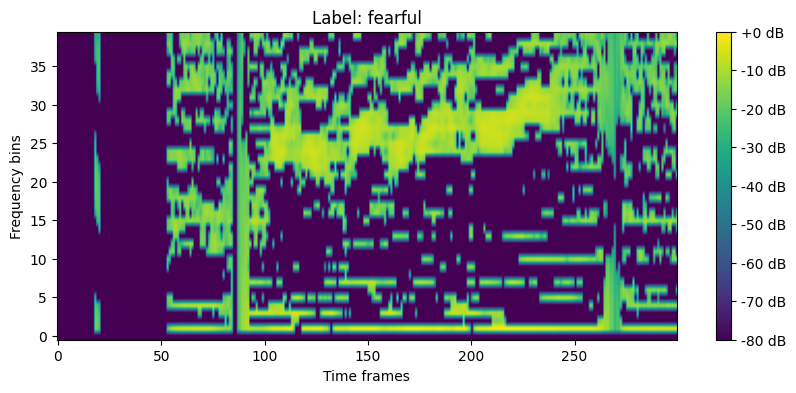

Playing audio file: /content/RAVDESS/Speech/Actor_02/03-01-06-01-01-01-02.wav


Validation sample index 0 visualization:
Emotion: happy
Sample shape: (40, 300)


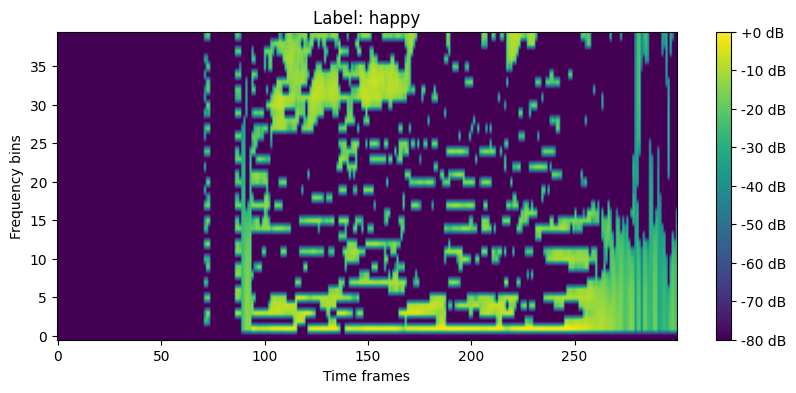

Playing audio file: /content/RAVDESS/Speech/Actor_16/03-01-03-01-01-01-16.wav


Test sample index 0 visualization:
Emotion: disgust
Sample shape: (40, 300)


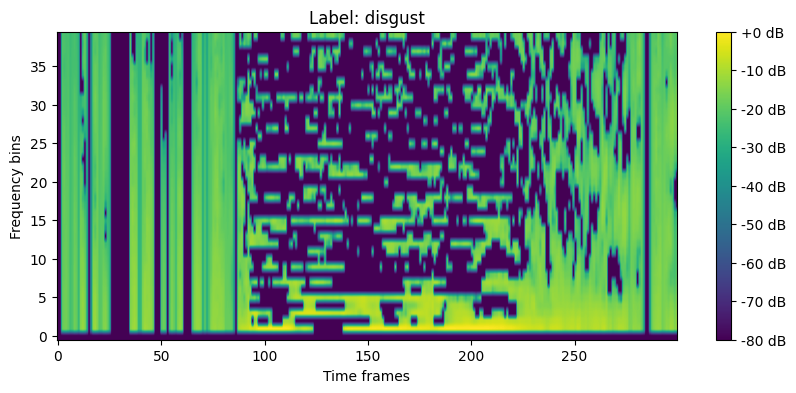

Playing audio file: /content/RAVDESS/Speech/Actor_13/03-01-07-01-02-02-13.wav


In [114]:
# Check a sample
sample_index = 0  # Change this index to visualize different samples

print(f'Training sample index {sample_index} visualization:')
audio_train = check_audio_sample(X_train, y_train, sample_index, label_encoder, audio_files=audio_files_train)
if audio_train:
    display(audio_train)

print(f'Validation sample index {sample_index} visualization:')
audio_val = check_audio_sample(X_val, y_val, sample_index, label_encoder, audio_files=audio_files_val)
if audio_val:
    display(audio_val)

print(f'Test sample index {sample_index} visualization:')
audio_test = check_audio_sample(X_test, y_test, sample_index, label_encoder, audio_files=audio_files_test)
if audio_test:
    display(audio_test)


# Build Model

In [115]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Input
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras.optimizers import Adam
import numpy as np

def assign_model_settings(num_labels, sparse_targets):
    if num_labels <= 2:
        loss_type = 'binary_crossentropy'
        activation_output = 'sigmoid'
    else:
        loss_type = 'categorical_crossentropy'
        activation_output = 'softmax'
    if sparse_targets:
        loss_type = 'sparse_categorical_crossentropy'
    return loss_type, activation_output

def buildmodel(model_type, num_labels, input_shape):
    model = Sequential()
    if 'cnn' == model_type.lower():
        # 1st Conv2D layer
        model.add(Conv2D(256, kernel_size=(5, 5), padding='same', input_shape=input_shape))
        model.add(Activation('relu'))

        # 2nd Conv2D layer
        model.add(Conv2D(128, kernel_size=(5, 5), padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
        model.add(Activation('relu'))
        model.add(Dropout(0.1))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # 3rd Conv2D layer
        model.add(Conv2D(128, kernel_size=(5, 5), padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
        model.add(Activation('relu'))

        # 4th Conv2D layer
        model.add(Conv2D(128, kernel_size=(5, 5), padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))

        # Add BatchNormalization before the Flatten layer
        model.add(BatchNormalization())

        # Flatten and Dense layers for classification
        model.add(Flatten())
        model.add(Dense(units=num_labels,
                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.l2(1e-4),
                        activity_regularizer=regularizers.l2(1e-5)))
        model.add(Activation('softmax'))
    return model

# Train Model

In [116]:
# Model settings
num_labels = len(np.unique(y_train))
loss_type, activation_output = assign_model_settings(num_labels, sparse_targets=True)

# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Debug: Print shapes of X_train and X_val
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)

# Adjust the input shape based on the data shape
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

feature_map_filters = 64
kernel_size = (5, 5)
pool_size = (2, 2)
dense_hidden_units = 128

# Build the model
model = buildmodel('cnn', num_labels, input_shape)

# Set the learning rate manually
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=loss_type, metrics=['accuracy'])

# Train the model without EarlyStopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60, batch_size=16)

Shape of X_train: (1008, 40, 300, 1)
Shape of X_val: (216, 40, 300, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.1651 - loss: 2.5994 - val_accuracy: 0.1898 - val_loss: 2.3905
Epoch 2/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3395 - loss: 2.0724 - val_accuracy: 0.2037 - val_loss: 2.3396
Epoch 3/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4469 - loss: 1.7777 - val_accuracy: 0.2407 - val_loss: 2.2877
Epoch 4/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6079 - loss: 1.3898 - val_accuracy: 0.4213 - val_loss: 2.2197
Epoch 5/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7788 - loss: 0.9998 - val_accuracy: 0.4583 - val_loss: 2.0516
Epoch 6/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8923 - loss: 0.6744 - val_accuracy: 0.5324 - val_loss: 1.8607
Epoch 7/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9505 - loss: 0.5361 - val_accuracy: 0.5880 - val_loss: 1.5973
Epoch 8/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9775 - loss: 0.4367 - val_accuracy: 0.5741 - v

**Why Use CNN-LSTM for Audio Data** <br/>
1.Feature Extraction with CNN: <br/>
-Spectrogram Conversion: Audio data is inherently a one-dimensional signal over time. To extract meaningful patterns, we often convert it into a 2D representation called a spectrogram. A spectrogram is a visual representation of the spectrum of frequencies in a sound signal as they vary with time. This is done using techniques like Short-Time Fourier Transform (STFT) or Mel-Frequency Cepstral Coefficients (MFCC) <br/>
-CNN for Feature Extraction: Convolutional Neural Networks (CNNs) excel at detecting spatial patterns in 2D data. When applied to spectrograms, CNNs can detect features such as edges, shapes, and textures that correspond to different sound characteristics and frequencies over time. These detected features can be crucial for identifying emotions expressed in the audio <br/>
2.Temporal Dynamics with LSTM: <br/>
Sequential Nature of Audio: Emotions in audio are expressed not just in isolated sounds but in how these sounds change over time. Capturing these temporal dynamics is essential for accurate emotion classification <br/>
LSTM for Temporal Modeling: Long Short-Term Memory (LSTM) networks are designed to handle sequential data and can capture long-term dependencies. After CNNs extract spatial features from each time slice of the spectrogram, LSTMs can analyze the sequence of these features to understand how they evolve over time. This helps in identifying the temporal patterns associated with different emotions <br/>
**How to Apply CNN-LSTM to Audio Data** <br/>
Here's a step-by-step explanation of the process: <br/>
1.Convert Audio to Spectrogram: <br/>
Audio Preprocessing: First, the audio data is preprocessed, which may include noise reduction, normalization, and segmentation <br/>
Spectrogram Generation: The preprocessed audio is then converted into a spectrogram. This involves breaking the audio into short overlapping segments and computing the frequency spectrum for each segment. The result is a 2D representation where one axis represents time and the other represents frequency, and the intensity of each point represents the amplitude of a specific frequency at a specific time <br/>
2.Apply CNN for Feature Extraction: <br/>
Convolutional Layers: The spectrogram is fed into a series of convolutional layers. These layers apply convolutional filters to detect local patterns in the time-frequency domain. Each filter can capture different features, such as frequency bands, harmonics, or pitch variations <br/>
Pooling Layers: Pooling layers are used to downsample the feature maps, reducing the dimensionality and focusing on the most important features <br/>
Dropout Layers: Dropout layers are included to prevent overfitting by randomly setting a fraction of the input units to zero during training.
Flattening: The final output of the CNN layers is a flattened feature vector that represents the spatial features extracted from the spectrogram.
3.Apply LSTM for Temporal Modeling: <br/>
TimeDistributed Wrapper: To apply CNN to each time step independently, the spectrogram can be divided into smaller overlapping time windows. The TimeDistributed wrapper ensures that the CNN processes each time window independently, producing a sequence of feature vectors.
LSTM Layers: These sequences of feature vectors are then fed into LSTM layers. The LSTM layers analyze the temporal sequence of these features, capturing how they change over time. This is crucial for understanding the temporal dynamics of the audio signal and for classifying the emotion based on these dynamics.
Output Layer: Finally, the LSTM's output is passed through a dense layer with a softmax or sigmoid activation function to produce the emotion classification <br/>
**Summary** <br/>
CNN extracts spatial features from each time slice of the spectrogram.
LSTM captures temporal dependencies between these features.
TimeDistributed ensures CNN is applied to each time step independently before passing the sequence of feature vectors to LSTM.

# Model Evaluation

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.6802 - loss: 1.1079
Test Loss: 1.067710041999817, Test Accuracy: 0.6805555820465088


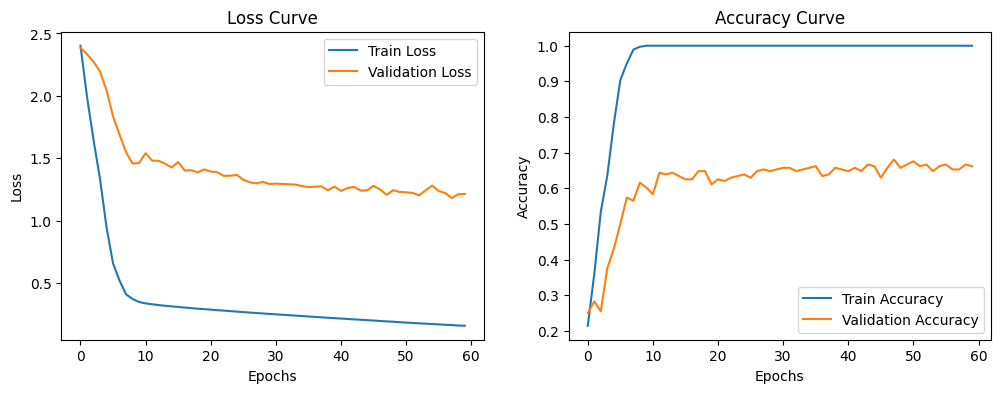

In [106]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/speech_emotion_model.h5')

# Make Predictions

In [ ]:
def predict_emotion_from_features(features, model, label_encoder):
    if features is not None:
        # Reshape the features to match the model input
        features = features[..., np.newaxis]  # Add channel dimension
        features = np.expand_dims(features, axis=0)  # Add batch dimension
        features = np.expand_dims(features, axis=1)  # Add time step dimension

        # Make prediction
        prediction = model.predict(features)

        # Decode the predicted label
        predicted_label = np.argmax(prediction, axis=1)
        predicted_emotion = label_encoder.inverse_transform(predicted_label)[0]

        return emotion_map.get(predicted_emotion, 'Unknown')
    else:
        return None


In [ ]:
# Load the trained model
model_path = 'model.h5'  # Path to the saved model
model = load_model(model_path)  # Load the trained model

# Assuming label_encoder is already created and fitted
# If not, you need to fit the label_encoder with the training labels again
label_encoder = LabelEncoder()
label_encoder.fit(y)

# Select an index from the test set
test_index = 0  # Change this index to select different samples

# Get the features and label for the selected test sample
test_features = X_test[test_index]
test_label = y_test[test_index]

# Predict the emotion of the test sample
predicted_emotion = predict_emotion_from_features(test_features, model, label_encoder)
actual_emotion = emotion_map.get(label_encoder.inverse_transform([test_label])[0], 'Unknown')

print(f'Actual Emotion: {actual_emotion}')
print(f'Predicted Emotion: {predicted_emotion}')

# Optionally, play the audio file
test_audio_path = file_paths_test[test_index]
audio_data, sr = librosa.load(test_audio_path, sr=None)
display(Audio(audio_data, rate=sr))
